{"username":"jcss03","key":"caf02cc87bdafff295f9eb6897072757"}

### Imports

In [ ]:
!pip install opendatasets
!pip install pandas

import opendatasets as od
import pandas
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Download data

In [ ]:
# download data from kaggle
od.download("https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis/download?datasetVersionNumber=2")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jcss03
Your Kaggle Key: ··········


100%|██████████| 1.99M/1.99M [00:00<00:00, 148MB/s]

In [ ]:
!ls ./twitter-entity-sentiment-analysis

twitter_training.csv  twitter_validation.csv


### Acesso ao Drive

In [ ]:
# Acesso a pasta do drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/'Trabalho de Graduação'/scripts

Exploratory_Analysis.ipynb  Processing_text.ipynb


### Loading Dataset

In [ ]:
dataset_train = pd.read_csv('./twitter-entity-sentiment-analysis/twitter_training.csv',names=['Tweet_ID','entity','sentiment','Tweet content'],header=None)
dataset_validation = pd.read_csv('./twitter-entity-sentiment-analysis/twitter_validation.csv',names=['Tweet_ID','entity','sentiment','Tweet content'],header=None)

In [ ]:
print('Exemplo do dataset')
dataset_train.sample(5)

Exemplo do dataset


,Tweet_ID,entity,sentiment,Tweet content
39581,5593,Hearthstone,Negative,@PlayHearthstone The servers are still working...
43030,10183,PlayerUnknownsBattlegrounds(PUBG),Neutral,All former players have become rookie hackers....
30305,7208,LeagueOfLegends,Positive,that!
58482,3227,Facebook,Positive,then why are you here crying about how youre t...
1626,2685,Borderlands,Neutral,"Borderlands 2(videogame) ""HANDSOME JACK IS GET..."


### Processing Text
* stopwords
* punctuation
* Stemming(reducing the words to their derived stems)
* Lemmatization(reducing the derived words to their root form known as lemma)
* removing unnecessary characters
* lower case text to better generalization

In [ ]:
data=dataset_train[['Tweet content','sentiment']].rename(columns={"Tweet content": "text", "sentiment": "target"})
data.target = pd.Categorical(data.target)

In [ ]:
# code mapping
dict(zip(data['target'].cat.codes,data['target']))

{3: 'Positive', 2: 'Neutral', 1: 'Negative', 0: 'Irrelevant'}

In [ ]:

data['code'] = data.target.cat.codes
print('#'*100)
print(f'Targets: {data.target.unique()}')
print(f'Codes: {data.code.unique()}')
print('#'*100)
data.sample(5)

####################################################################################################
Targets: ['Positive', 'Neutral', 'Negative', 'Irrelevant']
Categories (4, object): ['Irrelevant', 'Negative', 'Neutral', 'Positive']
Codes: [3 2 1 0]
####################################################################################################


,text,target,code
39151,Won Quest Rez Priest against Highlander Rogue ...,Neutral,2
5864,why it's so hard not to find shit online on am...,Negative,1
62854,Since Daniel made me get a car in GTA that ’ t...,Positive,3
2997,NaN,Positive,3
10939,"Bruhns. The sony unveiling was pointless, did ...",Negative,1


In [ ]:
print('#'*100)
qtd_null_values = np.sum(data.isnull().any(axis=1))
print(f'Shape dos dados: {data.shape}')
print(f'Number null values = {qtd_null_values}')

# dropna values
data = data.dropna().reset_index(drop=True)

print('#'*100)
qtd_null_values = np.sum(data.isnull().any(axis=1))
print(f'Shape dos dados: {data.shape}')
print(f'Number null values = {qtd_null_values}')

####################################################################################################
Shape dos dados: (74682, 3)
Number null values = 686
####################################################################################################
Shape dos dados: (73996, 3)
Number null values = 0


### Remover Pontuações

In [ ]:
# removing punctuation
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations

# maketrans explained - 'https://www.w3schools.com/python/ref_string_maketrans.asp'
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

print('#'*100)
original_sent = data.text.iloc[6]
print('Exemplo de remoção de pontuação')
print('--'*100)
print(f'Sentença Original:\n {original_sent}')
print('--'*100)
print(f'Sentença sem pontuação:\n {cleaning_punctuations(original_sent)}')
print('#'*100)

####################################################################################################
Exemplo de remoção de pontuação
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Sentença Original:
 So I spent a few hours making something for fun. . . If you don't know I am a HUGE @Borderlands fan and Maya is one of my favorite characters. So I decided to make myself a wallpaper for my PC. . Here is the original image versus the creation I made :) Enjoy! pic.twitter.com/mLsI5wf9Jg
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Sentença sem pontuação:
 So I spent a few hours making something for fun   If you dont know I am a HUGE Borderlands fan and Maya is one of my favorite charact

### Remover Stopwords

In [ ]:
# stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def remove_stopwords(text):
  stop_words = set(stopwords.words('english'))
  text = " ".join([word for word in text.split(' ') if word not in stop_words])
  return text

print('#'*100)
original_sent = data['text'].iloc[6]
print('Exemplo de remoção de stopwords')
print('--'*100)
print(f'Sentença Original:\n {original_sent}')
print(f'Tamanho da sentenca original: {len(original_sent)}')
print('--'*100)
rm_sent = remove_stopwords(original_sent)
print(f'Sentença sem stopwords:\n {rm_sent}')
print(f'Tamanho da sentenca sem stopWords: {len(rm_sent)}')
print('#'*100)

####################################################################################################
Exemplo de remoção de stopwords
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Sentença Original:
 So I spent a few hours making something for fun. . . If you don't know I am a HUGE @Borderlands fan and Maya is one of my favorite characters. So I decided to make myself a wallpaper for my PC. . Here is the original image versus the creation I made :) Enjoy! pic.twitter.com/mLsI5wf9Jg
Tamanho da sentenca original: 286
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Sentença sem stopwords:
 So I spent hours making something fun. . . If know I HUGE @Borderlands fan Maya one favorite charac

### Removendo repetições

In [ ]:
# removendo chars repetidos
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)

### Stemming

In [ ]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

def stemming(text):
  ps = PorterStemmer()
  text = " ".join([ps.stem(word) for word in text.split(' ')])
  return text

print('#'*100)
original_sent = data['text'].iloc[6]
print('Exemplo de Stemming')
print('--'*100)
print(f'Sentença Original:\n {original_sent}')
print(f'Tamanho da sentenca original: {len(original_sent)}')
print('--'*100)
stem_sent = stemming(original_sent)
print(f'Sentença stemming:\n {stem_sent}')
print(f'Tamanho da sentenca stemming: {len(stem_sent)}')
print('#'*100)

####################################################################################################
Exemplo de Stemming
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Sentença Original:
 So I spent a few hours making something for fun. . . If you don't know I am a HUGE @Borderlands fan and Maya is one of my favorite characters. So I decided to make myself a wallpaper for my PC. . Here is the original image versus the creation I made :) Enjoy! pic.twitter.com/mLsI5wf9Jg
Tamanho da sentenca original: 286
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Sentença stemming:
 so i spent a few hour make someth for fun. . . if you don't know i am a huge @borderland fan and maya is one of my f

### Lenmatization

In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
def lemmatizer_on_text(text):
    lm = nltk.WordNetLemmatizer()
    text = " ".join([lm.lemmatize(word) for word in text.split(' ')])
    return text

print('#'*100)
original_sent = data['text'].iloc[100]
print('Exemplo de Lemmatization')
print('--'*100)
print(f'Sentença Original:\n {original_sent}')
print(f'Tamanho da sentenca original: {len(original_sent)}')
print('--'*100)
lm_sent = lemmatizer_on_text(original_sent)
print(f'Sentença lemma:\n {lm_sent}')
print(f'Tamanho da sentenca lemma: {len(lm_sent)}')
print('#'*100)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


####################################################################################################
Exemplo de Lemmatization
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Sentença Original:
 Grounded almost was pretty cool even despite the top tier unfunny writing until we became yet another annoying crafting game. I seriously can’t wait on this shitty trend to die
Tamanho da sentenca original: 176
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Sentença lemma:
 Grounded almost wa pretty cool even despite the top tier unfunny writing until we became yet another annoying crafting game. I seriously can’t wait on this shitty trend to die
Tamanho da sentenca lemma: 175
#################

### Vizualization of **Words**

In [ ]:
X=data.text
y=data.target

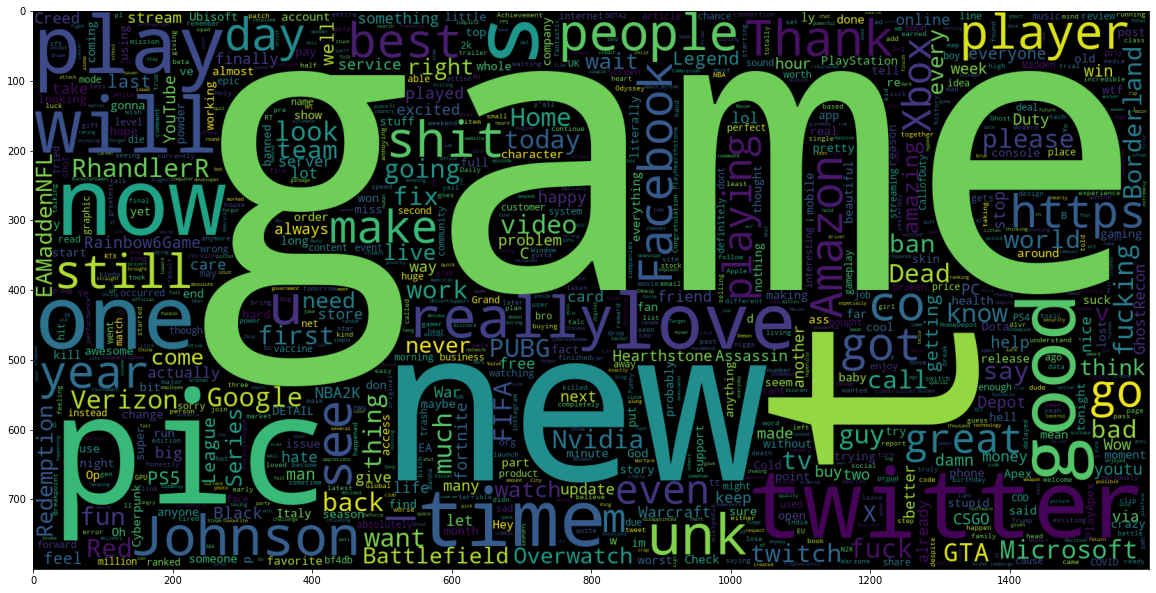

In [ ]:
data_example = data['text'][:50000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data['text']))
plt.imshow(wc)

### Função Completa

In [ ]:
import string
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# recebe texto e processa
def processing_text(text):

  ##############################################################################
  # funções

  # maketrans explained - 'https://www.w3schools.com/python/ref_string_maketrans.asp'
  def cleaning_punctuations(text):
      english_punctuations = string.punctuation
      punctuations_list = english_punctuations

      translator = str.maketrans('', '', punctuations_list)
      return text.translate(translator)
  
  # remover stopwords
  def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split(' ') if word not in stop_words])
    return text

  # removendo chars repetidos
  def cleaning_repeating_char(text):
      return re.sub(r'(.)1+', r'1', text)


  def lemmatizer(text):
      lm = nltk.WordNetLemmatizer()
      text = " ".join([lm.lemmatize(word) for word in text.split(' ')])
      return text
  ##############################################################################

  # Processing

  # lower all string of text
  text = text.lower()

  # remover pontuações
  text = cleaning_punctuations(text)

  # remover stopwords
  text = remove_stopwords(text)

  # remover repetições
  text = cleaning_repeating_char(text)

  # lenma
  text = lemmatizer(text)


  return text

In [ ]:
dataset_train['Tweet content'].iloc[100]

'Grounded almost was pretty cool even despite the top tier unfunny writing until we became yet another annoying crafting game. I seriously can’t wait on this shitty trend to die'

In [ ]:
processing_text(dataset_train['Tweet content'].iloc[100])

'grounded almost pretty cool even despite top tier unfunny writing became yet another annoying crafting game seriously can’t wait shitty trend die'

In [ ]:
data

,text,target,code
0,im getting on borderlands and i will murder yo...,Positive,3
1,I am coming to the borders and I will kill you...,Positive,3
2,im getting on borderlands and i will kill you ...,Positive,3
3,im coming on borderlands and i will murder you...,Positive,3
4,im getting on borderlands 2 and i will murder ...,Positive,3
...,...,...,...
73991,Just realized that the Windows partition of my...,Positive,3
73992,Just realized that my Mac window partition is ...,Positive,3
73993,Just realized the windows partition of my Mac ...,Positive,3
73994,Just realized between the windows partition of...,Positive,3


### Saving Processed Data

In [ ]:
# processing data

data = dataset_train[['Tweet content','sentiment']].rename(columns={"Tweet content": "text", "sentiment": "target"})
data.target = pd.Categorical(data.target)
data['code'] = data.target.cat.codes

# dropna values
data = data.dropna().reset_index(drop=True)

# processed text
data['processed_text'] = data['text'].apply(lambda x: processing_text(x))


In [ ]:
data.sample(5)

,text,target,code,processed_text
5156,Thank u amazon.,Positive,3,thank u amazon
13048,@ N2K _ MyTEAM @ N2K @ Ron2K is crap complete ...,Negative,1,n2k myteam n2k ron2k crap complete everyon...
35188,Are Xbox servers dead? (Or did I win hacked ),Negative,1,xbox server dead win hacked
59291,June 2020.........Facebook is a coward!,Negative,1,june 2020facebook coward
29143,Maybe only the edge of the screen lights up wh...,Neutral,2,maybe edge screen light erecting evo sign damn...


In [ ]:
!ls /content/drive/MyDrive/'Trabalho de Graduação'/scripts/data

In [ ]:
# saving data on drive folder
data.to_csv('/content/drive/MyDrive/''Trabalho de Graduação''/scripts/data/processed_data.csv',index=False)

In [ ]:
!ls /content/drive/MyDrive/'Trabalho de Graduação'/scripts/data

processed_data.csv


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/''Trabalho de Graduação''/scripts/data/processed_data.csv')
df.sample(5)

,text,target,code,processed_text
49493,No way FIFA done Sancho and Rio that dirty.....,Negative,1,way fifa done sancho rio dirty
57815,Why would I fuck your way to the bottom exactly?,Negative,1,would fuck way bottom exactly
61237,When the guys that’s been driving round and at...,Irrelevant,0,guy that’s driving round previous game finally...
30670,2008 Ranked as Gold 2 support main American le...,Neutral,2,2008 ranked gold 2 support main american leagu...
67512,Cyberpunk 2077 begs and begs me to enjoy the g...,Negative,1,cyberpunk 2077 begs begs enjoy game shoot foot...
